<a href="https://colab.research.google.com/github/KU-Gen-AI-2567/VAE-demo/blob/main/VAE_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE - 01418496

**สมาชิกกลุ่ม**

นายศิวกร ภาสว่าง 6410451423

นางสาว เเพรวรุ้ง พุดชะวา 6410451253

นางสาว มารีน่า มิทซุย 6410450222

หมู่ 200

ชุดข้อมูล : Smiling or Not | Face Data

link download : https://www.kaggle.com/datasets/chazzer/smiling-or-not-face-data

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import kagglehub
import shutil
import os
import numpy as np
from PIL import Image
tf.__version__

'2.17.1'

## Setting to execute on Processor (GPU or CPU)

In [ ]:
gpus = tf.config.list_physical_devices("GPU")
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("Execute on GPU")
else:
    print("Execute on CPU")

Execute on GPU


## Download Dataset

In [ ]:
# Download the dataset folder in latest version
if not "dataset" in os.listdir("."):
    path = kagglehub.dataset_download("chazzer/smiling-or-not-face-data")
    print("Path to dataset files:", path)
    shutil.move(path, "./dataset")
    print("Download Dataset Complete")
else:
    print("Download Dataset Already")

Download Dataset Already


## Prepossessing

In [ ]:
from tensorflow.keras import utils
import cv2 as cv

IMAGE_SIZE = (64, 64)
BATCH_SIZE = 128

def shuffle_images(images, seed=100):
    np.random.seed(seed)
    np.random.shuffle(images)

path = "./dataset"
class_names = ['non_smile', 'smile']
train_image = []
train_label = []
for class_name in enumerate(class_names):
    sub_path = f"{path}/{class_name[1]}"
    filenames = os.listdir(sub_path) # * Read filename in each dir 📁
    for filename in filenames:

        # * Preprocess 📄
        sub_sub_path = f"{path}/{class_name[1]}/{filename}"
        image = cv.imread(sub_sub_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = cv.resize(image, IMAGE_SIZE)
        image = tf.cast(image, "float32") / 255.0
        train_image.append(image)
        train_label.append(class_name[0])

seed = np.random.randint(1, 1000)
train_image = np.array(train_image)
shuffle_images(train_image, seed)
train_label = np.array(train_label)
shuffle_images(train_label, seed)

print(f"Shape of train_data: {train_image.shape}")
print(f"Shape of train_label: {train_label.shape}")
print(f"Classnames : {class_names}")


Shape of train_data: (1203, 64, 64, 3)
Shape of train_label: (1203,)
Classnames : ['non_smile', 'smile']


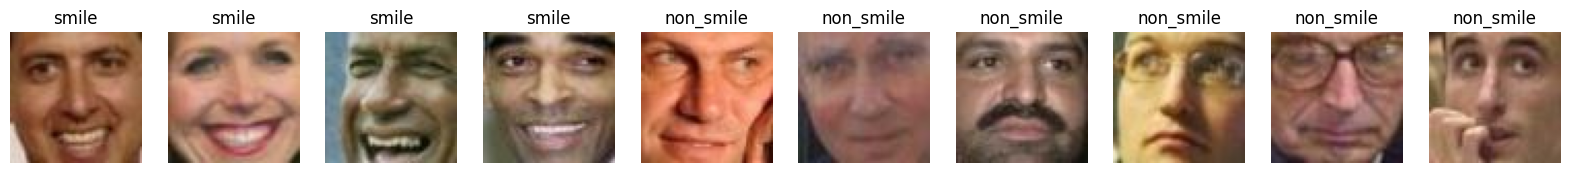

In [ ]:
import matplotlib.pyplot as plt

def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    batch = batch[0] if isinstance(batch, tuple) else batch
    return batch.numpy()

def display(images, labels, n=10, size=(20, 3), cmap="gray_r", as_type="float32"):
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)

    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.title(class_names[labels[i]])
        plt.axis("off")

    plt.show()

# train_sample = sample_batch(train_image)
display(train_image, train_label, cmap=None)

## Create Model

In [ ]:
# code for creating model
from tensorflow.keras import layers, activations, models
import tensorflow.keras.backend as K

Z_DIM = 500

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5*z_log_var) * epsilon

encoder_input = layers.Input(shape=(64, 64, 3), name="EncoderInput")
x = layers.Conv2D(256, (2, 2), activation=activations.leaky_relu, padding="same", strides=2)(encoder_input)
x = layers.Conv2D(128, (2, 2), activation=activations.leaky_relu, padding="same", strides=2)(x)
x = layers.Conv2D(256, (2, 2), activation=activations.leaky_relu, padding="same", strides=2)(x)

shape_before_flatten = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

encoder_model = models.Model(encoder_input, [z_mean, z_log_var, z], name="EncoderModel")
encoder_model.summary()

Model: "EncoderModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ EncoderInput (InputLayer) │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 32, 32, 256)    │          3,328 │ EncoderInput[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 16, 16, 128)    │        131,200 │ conv2d_29[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 8, 8, 256)      │        131,328 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_8 (Flatten)       │ (None, 16384)          │              0 │ conv2d_31[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 500)            │      8,192,500 │ flatten_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 500)            │      8,192,500 │ flatten_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_8 (Sampling)     │ (None, 500)            │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 16,650,856 (63.52 MB)

 Trainable params: 16,650,856 (63.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
decoder_input = layers.Input(shape=(Z_DIM, ), name='Decoder Input')
x = layers.Dense(tf.math.reduce_prod(shape_before_flatten).numpy())(decoder_input)
x = layers.Reshape(shape_before_flatten)(x)
x = layers.Conv2DTranspose(256, (2, 2), activation=activations.leaky_relu, padding='same', strides=2)(x)
x = layers.Conv2DTranspose(128, (2, 2), activation=activations.leaky_relu, padding='same', strides=2)(x)
x = layers.Conv2DTranspose(256, (2, 2), activation=activations.leaky_relu, padding='same', strides=2)(x)
decoder_output = layers.Conv2DTranspose(3, (2, 2), activation=activations.sigmoid, padding='same')(x)

decoder_model = models.Model(decoder_input, decoder_output, name="DecoderModel")
decoder_model.summary()

Model: "DecoderModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Decoder Input (InputLayer)           │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16384)               │       8,208,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_8 (Reshape)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_31                  │ (None, 16, 16, 256)         │         262,400 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_32                  │ (None, 32, 32, 128)         │         131,200 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_33                  │ (None, 64, 64, 256)         │         131,328 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_34                  │ (None, 64, 64, 3)           │           3,075 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,736,387 (33.33 MB)

 Trainable params: 8,736,387 (33.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import metrics, losses, optimizers

BETA = 2000

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(BETA * losses.MSE(data, reconstruction))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(BETA * losses.MSE(data, reconstruction))
        kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

vae = VAE(encoder_model, decoder_model)
vae.compile(optimizer=optimizers.AdamW(learning_rate=0.0001))

## Train Model

In [ ]:
# code for training model
from tensorflow.keras import callbacks

EPOCHS = 20

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        for i in range(self.num_img):
            utils.array_to_img(generated_images[i])

vae.fit(
    train_image,
    epochs=EPOCHS,
    callbacks=[ImageGenerator(num_img=10, latent_dim=Z_DIM)],
)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - kl_loss: 0.1114 - loss: 82.7769 - reconstruction_loss: 82.6655
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - kl_loss: 0.0509 - loss: 67.6689 - reconstruction_loss: 67.6180
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - kl_loss: 0.0807 - loss: 65.0001 - reconstruction_loss: 64.9194
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - kl_loss: 0.2430 - loss: 64.5180 - reconstruction_loss: 64.2750
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - kl_loss: 0.4291 - loss: 63.4881 - reconstruction_loss: 63.0590
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - kl_loss: 0.5552 - loss: 63.9979 - reconstruction_loss: 63.4427
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - kl_loss: 0.8313 - loss: 63.5620 - reconstruction_loss: 62.7307
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - kl_loss: 3.0495 - loss: 52.4064 - reconstruction_loss: 49.3570
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - kl_loss: 5.3719 -

## Visulization

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
Examples


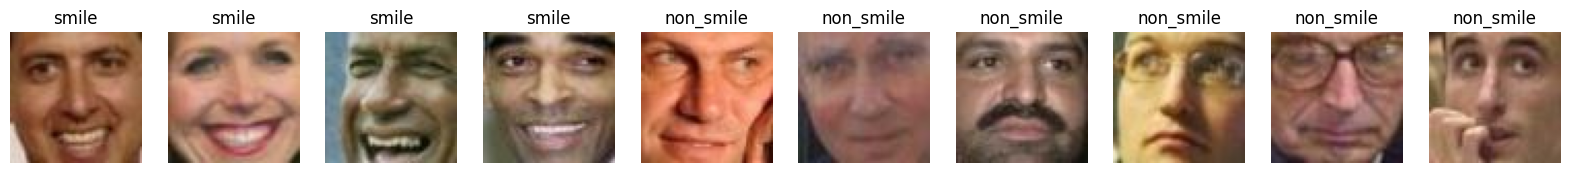

Reconstructions


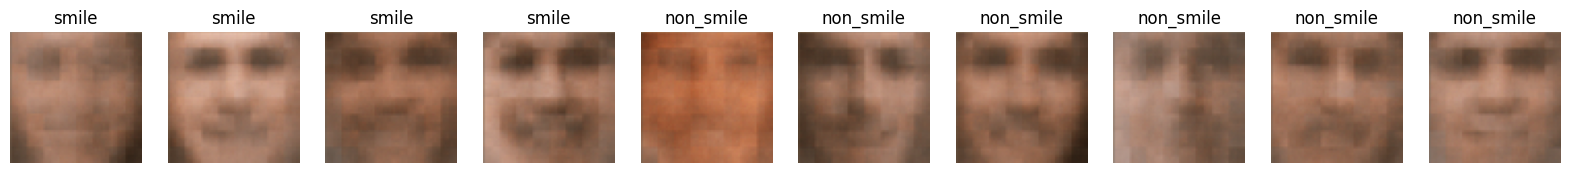

In [ ]:
# code for visulization 1
batches_to_predict = 1
example_images = train_image[:20]
z_mean, z_log_var, reconstructions = vae.predict(example_images)

print("Examples")
display(example_images, labels=train_label[:20])

print("Reconstructions")
display(reconstructions, labels=train_label[:20])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


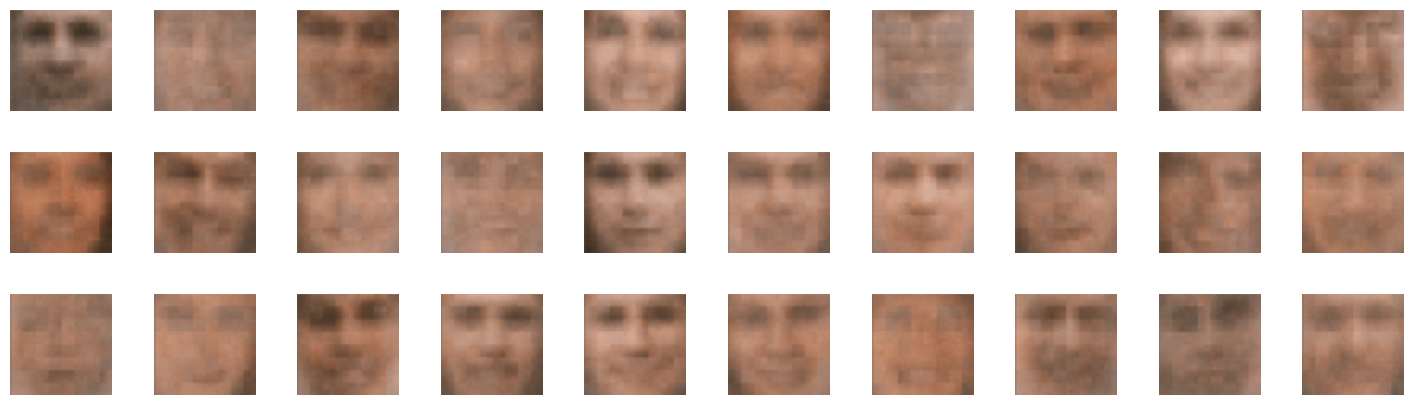

In [ ]:
# code for visulization 2
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))
reconstructions = decoder_model.predict(z_sample)
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])


## Member Participation

### รายละเอียดการมีส่วนร่วม
1. **นายศิวกร ภาสว่าง**
  - เขียนหัวข้อแต่ละ section สำหรับการเขียนโค้ด (Download Dataset, Prepossessing, Create Model, etc.)
  - ออกแบบ model ทั้ง enocoder และ decoder
  - แสดงภาพคนยิ้มและไม่ยิ้มที่ทำนายได้
2. **นางสาว เเพรวรุ้ง พุดชะวา**
  - content
  - content
3. **นางสาว มารีน่า มิทซุย**
  - content
  - content